# 6.2. Fine-Tuning CNN Multiclass Classification - Fashion MNIST Dataset
* "시작하세요! 텐서플로우 2.0 프로그래밍",
  * 6.4. 퍼포먼스 높이기, pp.161-172
    * 6.4.1. 더 많은 레이어 쌓기 pp.162-166
  
* Fashion MNIST 데이터세트를 CNN으로 훈련하는 문제입니다. 
* 단순한 구조지만 괜찮은 성능을 보이는 CNN 구조인 VGGNet 스타일 모델의 85% 정확도를 높이는 것이 목적입니다.
  * VGGNet은 여러 구조로 실험이 진행됐고, 웨이트 있는 레이어가 19개 있는 VGG-19가 가장 깊은 구조입니다.
  * (Conv2D x2 + MaxPool2D)x2 + (Conv2D x4 + MaxPool2D )x3 + Dense x3= 2x2 + 4x3 + 3 = 4+12+3=19
  * (Conv2D x2 + MaxPool2D)x2 + (Conv2D x4 + MaxPool2D )x3 = 3x2 + 5x3 = 6+15=21 이므로 안 맞음
* 더 많은 레이어를 쌓아서 성능을 높여봅니다.
* GPU Instance를 쓰지 않으면 시간이 많이 걸립니다.
  * AWS Instance를 ml.p2.xlarge로 변경합니다.
  * GPU 1개를 쓸 수 있습니다.
* P2 Instance Details
  * 상세한 내용은 [Amazon EC2 P2 Instances](https://aws.amazon.com/ec2/instance-types/p2/)를 참고하세요.

|     Name    | GPUs | vCPUs | RAM (GiB)      | Network Bandwidth | Price/Hour* | RI Price / Hour** |
|:-----------:|:----:|:-----:|:--------------:|:-----------------:|:-----------:|:-----------------:|
| p2.xlarge   |   1  |   4   |       61       |        High       |    $0.900   |       $0.425      |
| p2.8xlarge  |   8  |   32  |       488      |      10 Gbps      |    $7.200   |       $3.400      |
| p2.16xlarge |  16  |   64  |       732      |      20 Gbps      |   $14.400   |       $6.800      |

In [1]:
def show_an_image( numpy_ndarray, cmap=None ):
  # Fashion MNIST Dataset
  import matplotlib.pyplot as plt

  plt.imshow( numpy_ndarray, cmap )
  plt.colorbar()
  plt.show()
  
def plot_learning_curve( history ):

    import matplotlib.pyplot as plt
    plt.figure( figsize=(12,4) )

    plt.subplot( 1,2,1 )
    plt.plot( history.history['loss'], 'b-', label='loss' )
    plt.plot( history.history['val_loss'], 'r--', label='val_loss' )
    plt.xlabel( 'Epoch' )
    plt.legend()

    plt.subplot( 1, 2, 2 )
    plt.plot( history.history['accuracy'], 'g-', label='accuracy' )
    plt.plot( history.history['val_accuracy'], 'k--', label='val_accuracy' )
    plt.xlabel( 'Epoch' )
    plt.ylim( 0.7, 1 )
    plt.legend()

    plt.show()

In [2]:
def get_dataset():
  import tensorflow as tf

  fashion_mnist_module = tf.keras.datasets.fashion_mnist
  (train_x, train_y), (test_x, test_y) = fashion_mnist_module.load_data()

  # Normalize data
  train_x = train_x / 255.0
  test_x = test_x / 255.0

  train_x = train_x.reshape(-1, 28, 28, 1)
  test_x = test_x.reshape(-1, 28, 28, 1)

  return (train_x, train_y), (test_x, test_y)

In [3]:
(train_x, train_y), (test_x, test_y) = get_dataset()

4423680/4422102 [==============================] - 0s 0us/step


### 6.4.1. 더 많은 레이어 쌓기

In [4]:
import tensorflow as tf

# VGG-like architecture: it's like VGG-7

model = tf.keras.Sequential([
  # Feature extractor
  tf.keras.layers.Conv2D( input_shape=(28,28,1), kernel_size=(3,3), filters=32, padding='same', activation='relu' ),
  tf.keras.layers.Conv2D( kernel_size=(3,3), filters=64, padding='same', activation='relu' ),
  tf.keras.layers.MaxPool2D( pool_size=(2,2) ), 
  tf.keras.layers.Dropout( rate=0.5 ),
  tf.keras.layers.Conv2D( kernel_size=(3,3), filters=128, padding='same', activation='relu' ),
  tf.keras.layers.Conv2D( kernel_size=(3,3), filters=256, padding='valid', activation='relu' ), # valid, not same!
  tf.keras.layers.MaxPool2D( pool_size=(2,2) ),
  tf.keras.layers.Dropout( rate=0.5 ),
  # Classifier
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense( units=512, activation='relu'),
  tf.keras.layers.Dropout( rate=0.5 ),
  tf.keras.layers.Dense( units=256, activation='relu'),
  tf.keras.layers.Dropout( rate=0.5 ),
  tf.keras.layers.Dense( units=10, activation='softmax')
])

model.compile( optimizer=tf.keras.optimizers.Adam(),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'] )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 256)         0

In [5]:
history = model.fit( train_x, train_y, epochs=25, validation_split=0.25 )

Train on 45000 samples, validate on 15000 samples
Epoch 1/25
45000/45000 [==============================] - 70s 2ms/sample - loss: 0.5919 - accuracy: 0.7868 - val_loss: 0.3332 - val_accuracy: 0.8759
Epoch 2/25
45000/45000 [==============================] - 24s 538us/sample - loss: 0.3668 - accuracy: 0.8680 - val_loss: 0.2869 - val_accuracy: 0.8939
Epoch 3/25
45000/45000 [==============================] - 24s 538us/sample - loss: 0.3236 - accuracy: 0.8827 - val_loss: 0.2596 - val_accuracy: 0.9035
Epoch 4/25
45000/45000 [==============================] - 24s 540us/sample - loss: 0.3025 - accuracy: 0.8905 - val_loss: 0.2571 - val_accuracy: 0.9011
Epoch 5/25
45000/45000 [==============================] - 24s 542us/sample - loss: 0.2914 - accuracy: 0.8939 - val_loss: 0.2450 - val_accuracy: 0.9083
Epoch 6/25
45000/45000 [==============================] - 23s 516us/sample - loss: 0.2764 - accuracy: 0.8999 - val_loss: 0.2271 - val_accuracy: 0.9141
Epoch 7/25
45000/45000 [======================

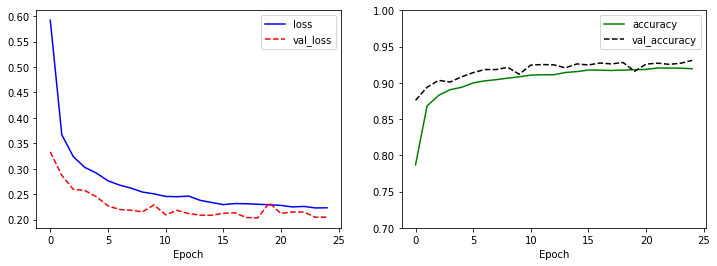

In [6]:
plot_learning_curve( history )

In [7]:
model.evaluate( test_x, test_y, verbose=0 )

[0.21762712924480437, 0.9271]

* 이제는 validation loss가 loss와 같이 떨어지는 정상적인 결과를 얻을 수 있습니다.
* Accuracy와 Validation Accuracy도 유사하게 높아집니다.
* 테스트 성능은 91.69%로 추가로 높아졌습니다.